In [10]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
np.set_printoptions(precision=3)
import sys
sys.path.append('../../zdrojaky')
from tsplot import tsplot

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, DeprecationWarning))

# Modelování časové řady COVID-19 pomocí ARMA modelu

*Zdroj dat: https://onemocneni-aktualne.mzcr.cz/api/v1/covid-19*

Uvažujme datovou sadu poskytovanou MZ ČR s následujícím popisem:

```Datová sada obsahující kumulativní denní počty osob s prokázaným onemocněním COVID-19 dle hlášení krajských hygienických stanic včetně laboratoří, denní počty vyléčených po onemocnění COVID‑19 dle hlášení krajských hygienických stanic, denní počty úmrtí v souvislosti s onemocněním COVID‑19 dle hlášení krajských hygienických stanic a hospitalizačních úmrtí, a denní počty provedených testů na onemocnění COVID-19 dle hlášení laboratoří. S ohledem na fakt, že vykazování vyléčených osob a úmrtí má určité zpoždění oproti reálnému stavu z důvodu validace a uzavírání případů krajských hygienických stanic, se mohou denní záznamy zpětně měnit právě z důvodu průběžného doplňování.```

Jelikož poskytovatel nedává schema CSV k první verzi automaticky, budeme si muset data sami prozkoumat :)



In [2]:
# fn = 'https://onemocneni-aktualne.mzcr.cz/api/v1/covid-19/nakazeni-vyleceni-umrti-testy.csv'
fn = 'nakazeni-vyleceni-umrti-testy.csv'
data = pd.read_csv(fn, index_col=0, parse_dates=True, infer_datetime_format=True)
data.head()

,kumulovany_pocet_nakazenych,kumulovany_pocet_vylecenych,kumulovany_pocet_umrti,kumulovany_pocet_provedenych_testu,kumulovany_pocet_provedenych_ag_testu,prirustkovy_pocet_nakazenych,prirustkovy_pocet_vylecenych,prirustkovy_pocet_umrti,prirustkovy_pocet_provedenych_testu,prirustkovy_pocet_provedenych_ag_testu
datum,,,,,,,,,,
2020-01-27,0,0,0,20,0,0,0,0,20,0
2020-01-28,0,0,0,28,0,0,0,0,8,0
2020-01-29,0,0,0,33,0,0,0,0,5,0
2020-01-30,0,0,0,34,0,0,0,0,1,0
2020-01-31,0,0,0,37,0,0,0,0,3,0


Data jsou stejná jako minulý týden. Podívejme se na ně:

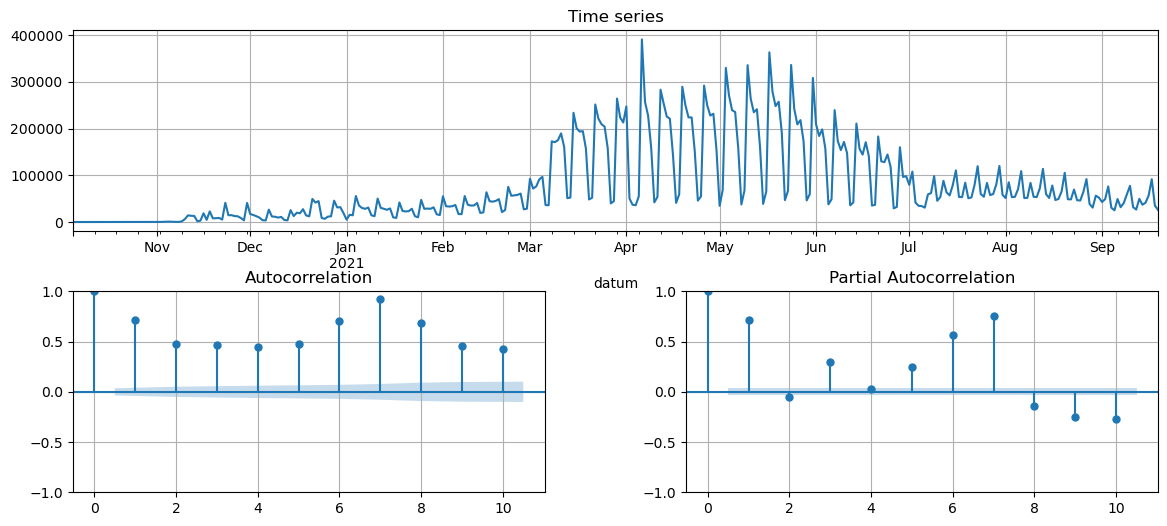

In [3]:
df = data['prirustkovy_pocet_provedenych_ag_testu'].last('50W')
df = df.asfreq('D')

tsplot(df, lags=10)

Stejně jako minulý týden budeme pracovat na týdenních součtech. Zkuste postupovat samostatně:

1. pomocí `df.resample()` převeďte data na týdenní součty a analyzujte ACF a PACF.
2. zkuste řadu diferencovat (`df.diff()`) a opět analyzujte ACF a PACF. Můžete zkusit i více diferencí a zkusit odhadnout, kolik jich pomůže nejvíc.
3. zkuste vybrat vhodný ARIMA model. Využijte třídu `ARIMA` z minule. Pro odhad řádů AR a MA můžete využít `arma_order_select_ic()` z minule, metodu pokus-omyl a nebo balík `pmdarima` a v něm funkci `auto_arima()`.
4. model odhadněte a proveďte diagnostiku reziduí (viz `plot_diagnostics()` z minule)
5. získejte predikce na několik týdnů dopředu.